# Analyzing Customer-Music Data using Apache Spark (PySpark)

The original Drill & Tableau based tutorial is at https://mapr.com/blog/real-time-user-profiles-spark-drill-and-mapr-db/. I have converted them to PySpark 2.2 Jupyter Notebooks. In addition to that I have added many more Spark based Data Analysis sections, Side by Side Spark comparisons DF API and Spark SQL constructs to realize the same use case. Also used Jupyter Notebook for data visualization.

A special section for working with RDDs is also included.

Users are continuously connecting to the service and listening to tracks that they like -- this generates our main data set. The behaviors captured in these events, over time, represent the highest level of detail about actual behaviors of customers as they consume the service by listening to music. In addition to the events of listening to individual tracks, we have a few other data sets representing all the information we might normally have in such a service. In this post we will make use of the following three data sets.

**How to Configure Jupter Notebook to run Spark 2.2:**
```
1. Create an Anaconda environment 'pyspark' (Follow instructions here https://conda.io/docs/user-guide/tasks/manage-environments.html#creating-an-environment-with-commands)
   conda create -n pyspark python=3.5
2. Switch to pyspark anaconda environment 
   source activate pyspark
3. Install pspark from Pypi. This package will directly communicate with Spark
   pip install pyspark 
4. Install Spark in your machine (from here: https://spark.apache.org/downloads.html). I installed spark-2.4.0-bin-hadoop2.7.tgz
5. In your .bash_profile set the following
    export SPARK_HOME=/home/ubuntu/spark-2.4.0-bin-hadoop2.7
    export ANACONDA_PYSPARK_ENV_HOME=/home/ubuntu/anaconda/envs/pyspark
    PATH=$SPARK_HOME/bin:$ANACONDA_PYSPARK_ENV_HOME/bin:$PATH
    export PATH
    
    There is further better way to set the environment variables for anaconda but for now it is fine.
6. Open another terminal to make these changes effective or issue the below commond from the same terminal
    source ~.bash_profile
7. Start the jupyter notebook from that environment.
   jupyter notebook
```

## 1. Understanding the Data Set

**Individual customers listening to individual tracks: (tracks.csv)** - a collection of events, one per line, where each event is a client listening to a track.

This data is approximately 1M lines and contains simulated listener events over several months.

<table>
  <tr>
    <th><strong>Field Name</strong></th>
    <th>Event ID</th>
    <th>Customer ID</th>
    <th>Track ID</th>
    <th>Datetime</th>
    <th>Mobile</th>
    <th>Listening Zip</th>
  </tr>
  <tr>
    <td><strong>Type</strong></td>
    <td>Integer</td>
    <td>Integer</td>
    <td>Integer</td>
    <td>String</td>
    <td>Integer</td>
    <td>Integer</td>
  </tr>
  <tr>
    <td><strong>Example Value</strong></td>
    <td>9999767</td>
    <td>2597</td>
    <td>788</td>
    <td>2014-12-01 09:54:09</td>
    <td>0</td>
    <td>11003</td>
  </tr>
</table>

The event, customer and track IDs tell us what occurred (a customer listened to a certain track), while the other fields tell us some associated information, like whether the customer was listening on a mobile device and a guess about their location while they were listening. With many customers listening to many tracks, this data can get very large and will be the input into our Spark job.

**Customer information:** - information about individual customers.

<table>
  <tr>
    <th><strong>Field Name</strong></th>
    <th>Customer ID</th>
    <th>Name</th>
    <th>Gender</th>
    <th>Address</th>
    <th>ZIP</th>
    <th>Sign Date</th>    
    <th>Status</th>
    <th>Level</th>
    <th>Campaign</th>
    <th>Linked with Apps?</th>
  </tr>
  <tr>
    <td><strong>Type</strong></td>
    <td>Integer</td>
    <td>String</td>
    <td>Integer</td>
    <td>String</td>
    <td>Integer</td>
    <td>String</td>
    <td>Integer</td>
    <td>Integer</td>
    <td>Integer</td>
    <td>Integer</td>    
  </tr>
  <tr>
    <td><strong>Example Value</strong></td>
    <td>10</td>
    <td>Joshua Threadgill</td>
    <td>0</td>
    <td>10084 Easy Gate Bend</td>
    <td>66216</td>
    <td>01/13/2013</td>
    <td>0</td>
    <td>1</td>
    <td>1</td>
    <td>1</td>
  </tr>
</table>


The fields are defined as follows:
```
Customer ID: a unique identifier for that customer
Name, gender, address, zip: the customer’s associated information
Sign date: the date of addition to the service
Status: indicates whether or not the account is active (0 = closed, 1 = active)
Level: indicates what level of service -- 0, 1, 2 for Free, Silver and Gold, respectively
Campaign: indicates the campaign under which the user joined, defined as the following (fictional) campaigns driven by our (also fictional) marketing team:
NONE - no campaign
30DAYFREE - a ‘30 days free’ trial offer
SUPERBOWL - a Superbowl-related program
RETAILSTORE - an offer originating in brick-and-mortar retail stores
WEBOFFER - an offer for web-originated customers
```

**Previous ad clicks: (clicks.csv)** - a collection of user click events indicating which ad was played to the user and whether or not they clicked on it.

<table>
  <tr>
    <th><strong>Field Name</strong></th>
    <th><strong>EventID</strong></th>
    <th>CustID</th>
    <th>AdClicked</th>
    <th>Localtime</th>
  </tr>
  <tr>
    <td><strong>Type</strong></td>
    <td>Integer</td>
    <td>Integer</td>
    <td>String</td>
    <td>String</td>
  </tr>
  <tr>
    <td><strong>Example Value</strong></td>
    <td>0</td>
    <td>109</td>
    <td>ADV_FREE_REFERRAL</td>
    <td>2014-12-01 09:54:09</td>
  </tr>
</table>

The fields that interest us are the foreign key identifying the customer (CustID), a string indicating which ad they clicked (AdClicked), and the time when it happened (Localtime). Note that we could use a lot more features here, such as basic information about the customer (gender, etc.), but to keep things simple for the example we’ll leave that as a future exercise.

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (6,4)})
rcParams['figure.figsize'] = 6,4

# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# setting random seed for notebook reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 2. Creating the Spark Session

In [5]:
os.environ['SPARK_HOME']

'/home/ubuntu/spark-2.4.0-bin-hadoop2.7'

In [6]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("music-customer-analysis-with-pyspark")
         .getOrCreate())

In [7]:
spark

In [8]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=music-customer-analysis-with-pyspark>

In [9]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

## 3. Load the data from files into DataFrames

In [10]:
MUSIC_TRACKS_DATA = 'data/tracks.csv'
CUSTOMER_DATA     = 'data/cust.csv'
CLICKS_DATA       = 'data/clicks.csv'

In [11]:
# define the schema, corresponding to a line in the csv data file for music
music_schema = StructType([
    StructField('event_id', IntegerType(), nullable=True),
    StructField('customer_id', IntegerType(), nullable=True),
    StructField('track_id', StringType(), nullable=True),
    StructField('datetime', StringType(), nullable=True),
    StructField('is_mobile', IntegerType(), nullable=True),
    StructField('zip', IntegerType(), nullable=True)]
  )

In [12]:
# define the schema, corresponding to a line in the csv data file for customer
cust_schema = StructType([
    StructField('customer_id', IntegerType(), nullable=True),
    StructField('name', StringType(), nullable=True),
    StructField('gender', IntegerType(), nullable=True),
    StructField('address', StringType(), nullable=True),
    StructField('zip', IntegerType(), nullable=True),
    StructField('sign_date', StringType(), nullable=True),
    StructField('status', IntegerType(), nullable=True),
    StructField('level', IntegerType(), nullable=True),
    StructField('campaign', IntegerType(), nullable=True),
    StructField('lnkd_with_apps', IntegerType(), nullable=True)]
  )

In [13]:
# define the schema, corresponding to a line in the csv data file for ad click
click_schema = StructType([
    StructField('event_id', IntegerType(), nullable=True),
    StructField('customer_id', IntegerType(), nullable=True),
    StructField('ad_clicked', IntegerType(), nullable=True),
    StructField('datetime', StringType(), nullable=True)]
  )

In [14]:
# Load data
music_df = spark.read.csv(path=MUSIC_TRACKS_DATA, schema=music_schema).cache()
music_df.createOrReplaceTempView("music")

cust_df = spark.read.csv(path=CUSTOMER_DATA, schema=cust_schema, header=True).cache()
cust_df.createOrReplaceTempView("cust")

click_df = spark.read.csv(path=CLICKS_DATA, schema=click_schema, header=True).cache()
click_df.createOrReplaceTempView("click")

In [15]:
# How many music data rows
music_df.count()

1000000

In [16]:
music_df.show(5)

+--------+-----------+--------+-------------------+---------+-----+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|
+--------+-----------+--------+-------------------+---------+-----+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|
+--------+-----------+--------+-------------------+---------+-----+
only showing top 5 rows



In [17]:
# How many customer data rows
cust_df.count()

5000

In [18]:
cust_df.show(5)

+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|customer_id|         name|gender|             address|  zip| sign_date|status|level|campaign|lnkd_with_apps|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|          0|Gregory Koval|     0|13004 Easy Cider ...|72132|06/04/2013|     1|    1|       1|             0|
|          1|Robert Gordon|     0|10497 Thunder Hic...|17307|07/27/2013|     1|    1|       1|             0|
|          2|Paula Peltier|     0|10084 Easy Gate Bend|66216|01/13/2013|     1|    0|       4|             1|
|          3|Francine Gray|     0|54845 Bent Pony H...|36690|07/11/2013|     1|    1|       1|             1|
|          4| David Garcia|     0|8551 Tawny Fox Villa|61377|09/09/2012|     1|    0|       1|             1|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
only showi

In [19]:
# How many ads click data rows
click_df.count()

65710

## 4. Data Exploration

### 4.1 Compute Hourly Summary profile of each customer:

We will now see customers' listening behaviour across various hours in the day. Whether they tend to listen more in the morning or night, statistics like that.

**Add a new Hour Column to the Music data:**

In [20]:
hourly_music_df = music_df.withColumn('hour', F.hour('datetime')).cache()

In [21]:
hourly_music_df.show(5)

+--------+-----------+--------+-------------------+---------+-----+----+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|hour|
+--------+-----------+--------+-------------------+---------+-----+----+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|   3|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|  18|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|  15|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|   2|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|   7|
+--------+-----------+--------+-------------------+---------+-----+----+
only showing top 5 rows



**Divide the entire day into four time buckets based on the hour:**  

Bucket the listen datetime into different buckets in the day e.g. night, morning, afternoon or evening and mark 1 if the song is listened in that bucket.

In [22]:
hourly_music_df = (hourly_music_df
    .withColumn('night', F.when((col('hour') < 5) | (col('hour') >= 22), 1).otherwise(0))
    .withColumn('morn', F.when((col('hour') >= 5) & (col('hour') < 12), 1).otherwise(0))
    .withColumn('aft', F.when((col('hour') >= 12) & (col('hour') < 17), 1).otherwise(0))
    .withColumn('eve', F.when((col('hour') >= 17) & (col('hour') < 22), 1).otherwise(0))
    .cache())

In [23]:
hourly_music_df.filter('night == 1').count()

291516

### 4.1.1 Compute Customer Hourly Summary using DF API:

Now we're ready to compute a summary profile for each user. We will leverage PySpark SQL functions compute some high-level data:

+ Average number of tracks listened during each period of the day: morning, afternoon, evening, and night. We arbitrarily define the time ranges in the code.
+ Total unique tracks listened by that user, i.e. the set of unique track IDs.
+ Total mobile tracks listened by that user, i.e. the count of tracks that were listened that had their mobile flag set.

In [24]:
cust_profile_df = (hourly_music_df.select(['customer_id', 'track_id', 'night', 'morn', 'aft', 'eve', 'is_mobile'])
     .groupBy('customer_id')
     .agg(F.countDistinct('track_id'), F.sum('night'), F.sum('morn'), F.sum('aft'), F.sum('eve'), F.sum('is_mobile'))).cache()

In [25]:
cust_profile_df.show(10)

+-----------+------------------------+----------+---------+--------+--------+--------------+
|customer_id|count(DISTINCT track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-----------+------------------------+----------+---------+--------+--------+--------------+
|        148|                     443|       149|      170|     109|     124|           476|
|        463|                     306|       103|       99|      84|      76|           176|
|       1591|                     171|        47|       64|      36|      40|            85|
|       2366|                     143|        55|       46|      30|      25|           113|
|       4101|                     100|        31|       28|      26|      22|            85|
|       1342|                     173|        53|       60|      36|      42|           102|
|       2659|                     119|        42|       43|      22|      22|            59|
|       1238|                     191|        72|       64|      30|  

### 4.1.2 Compute Customer Hourly Summary using SQL:

In the previous sections we used only DF APIs to calculate the hourly profiles. However, we can use pure Spark SQL to achieve the same results. That would be much less verbose. We will still leverage PySpark SQL functions compute those high-level data:

+ Average number of tracks listened during each period of the day: morning, afternoon, evening, and night. We arbitrarily define the time ranges in the code.
+ Total unique tracks listened by that user, i.e. the set of unique track IDs.
+ Total mobile tracks listened by that user, i.e. the count of tracks that were listened that had their mobile flag set.

**Divide the entire day into four time buckets based on the hour:**  

Bucket the listen datetime into different buckets in the day e.g. night, morning, afternoon or evening and mark 1 if the song is listened in that bucket.

In [26]:
spark.sql(
"""
SELECT  *, 
        HOUR(datetime) as hour, 
        CASE WHEN HOUR(datetime) < 5 OR HOUR(datetime) >= 22 THEN 1 ELSE 0 END AS night,
        CASE WHEN HOUR(datetime) >= 5 AND HOUR(datetime) < 12 THEN 1 ELSE 0 END AS morn,
        CASE WHEN HOUR(datetime) >= 12 AND HOUR(datetime) < 17 THEN 1 ELSE 0 END AS aft,
        CASE WHEN HOUR(datetime) >= 17 AND HOUR(datetime) < 22 THEN 1 ELSE 0 END AS eve
FROM music
""").show(10)

+--------+-----------+--------+-------------------+---------+-----+----+-----+----+---+---+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|hour|night|morn|aft|eve|
+--------+-----------+--------+-------------------+---------+-----+----+-----+----+---+---+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|   3|    1|   0|  0|  0|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|  18|    0|   0|  0|  1|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|  15|    0|   0|  1|  0|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|   2|    1|   0|  0|  0|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|   7|    0|   1|  0|  0|
|       5|       1811|       6|2014-11-18 02:00:48|        1|20115|   2|    1|   0|  0|  0|
|       6|       3644|      24|2014-12-12 15:24:02|        1|15330|  15|    0|   0|  1|  0|
|       7|        250|     726|2014-10-07 09:48:53|        0|33570|   9|    0|  

**Compute the hourly profiles:**  

We can combine the above bucketing and calculating the hourly summary in one SQL as follows.

In [27]:
spark.sql(
"""
SELECT customer_id, COUNT(DISTINCT track_id), SUM(night), SUM(morn), SUM(aft), SUM(eve), SUM(is_mobile) 
FROM(
    SELECT  *, 
            HOUR(datetime) as hour, 
            CASE WHEN HOUR(datetime) < 5 OR HOUR(datetime) >= 22 THEN 1 ELSE 0 END AS night,
            CASE WHEN HOUR(datetime) >= 5 AND HOUR(datetime) < 12 THEN 1 ELSE 0 END AS morn,
            CASE WHEN HOUR(datetime) >= 12 AND HOUR(datetime) < 17 THEN 1 ELSE 0 END AS aft,
            CASE WHEN HOUR(datetime) >= 17 AND HOUR(datetime) < 22 THEN 1 ELSE 0 END AS eve
    FROM music)
GROUP BY customer_id
""").show(10)

+-----------+------------------------+----------+---------+--------+--------+--------------+
|customer_id|count(DISTINCT track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-----------+------------------------+----------+---------+--------+--------+--------------+
|        148|                     443|       149|      170|     109|     124|           476|
|        463|                     306|       103|       99|      84|      76|           176|
|       1591|                     171|        47|       64|      36|      40|            85|
|       2366|                     143|        55|       46|      30|      25|           113|
|       4101|                     100|        31|       28|      26|      22|            85|
|       1342|                     173|        53|       60|      36|      42|           102|
|       2659|                     119|        42|       43|      22|      22|            59|
|       1238|                     191|        72|       64|      30|  

We can see the result is same as the results form the DF APIs.

### 4.2 Summary Statistics:

Since we have the summary data readily available we compute some basic statistics on it.

In [28]:
# Referring to cust_profile_df from section 4.1.1 we can use the describe() function to get the summary statistics
cust_profile_df.select([c for c in cust_profile_df.columns if c not in ['customer_id']]).describe().show()

+-------+------------------------+-----------------+----------------+-----------------+-----------------+------------------+
|summary|count(DISTINCT track_id)|       sum(night)|       sum(morn)|         sum(aft)|         sum(eve)|    sum(is_mobile)|
+-------+------------------------+-----------------+----------------+-----------------+-----------------+------------------+
|  count|                    5000|             5000|            5000|             5000|             5000|              5000|
|   mean|                 170.295|          58.3032|         58.2908|          41.6434|          41.7626|           121.553|
| stddev|      117.04437556828793|67.27232404842705|67.3964412370437|47.87538247251274|48.01370329792189|148.79537090743347|
|    min|                      68|               15|              16|                9|                9|                32|
|    max|                    1617|             2139|            2007|             1460|             1480|              5093|


In [29]:
# store the describe dataframe temporarily
summary_stats_df = cust_profile_df.select([c for c in cust_profile_df.columns if c not in ['customer_id']]).describe()

#### 4.2.1 Prettifying Summary Statistics:

There are too many decimal places for mean and stddev in the describe() dataframe. We can format the numbers to just show up to two decimal places. Pay careful attention to the datatypes that describe() returns, its a String, we need to cast that to a float before we can format. We use cast() and format_number() on individual columns to reformat.

In [30]:
summary_stats_df.select(summary_stats_df['summary'], 
            F.format_number(summary_stats_df['count(DISTINCT track_id)'].cast('float'), 2).alias('count(DISTINCT track_id)'), 
            F.format_number(summary_stats_df['sum(night)'].cast('float'), 2).alias('sum(night)'),
            F.format_number(summary_stats_df['sum(morn)'].cast('float'), 2).alias('sum(morn)'), 
            F.format_number(summary_stats_df['sum(aft)'].cast('float'), 2).alias('sum(aft)'),
            F.format_number(summary_stats_df['sum(is_mobile)'].cast('float'), 2).alias('sum(is_mobile)')).show()

+-------+------------------------+----------+---------+--------+--------------+
|summary|count(DISTINCT track_id)|sum(night)|sum(morn)|sum(aft)|sum(is_mobile)|
+-------+------------------------+----------+---------+--------+--------------+
|  count|                5,000.00|  5,000.00| 5,000.00|5,000.00|      5,000.00|
|   mean|                  170.29|     58.30|    58.29|   41.64|        121.55|
| stddev|                  117.04|     67.27|    67.40|   47.88|        148.80|
|    min|                   68.00|     15.00|    16.00|    9.00|         32.00|
|    max|                1,617.00|  2,139.00| 2,007.00|1,460.00|      5,093.00|
+-------+------------------------+----------+---------+--------+--------------+



#### 4.2.2 Prettifying Summary Statistics - Even Smarter:

In real life data sets there would be too many columns. Specifying each columm in the codes would not be feasible. We can use list comprehension of Python of for loops to do this smartly. We can even exclude some columns we dont' want.

**Apply for loop on formatting columns and excluding the summary column:**

In [31]:
# loop over the column names and format
for col_name in summary_stats_df.columns:
    if col_name not in ['summary']:
        summary_stats_df = summary_stats_df.withColumn(col_name, F.format_number(col(col_name).cast('float'), 2))

In [32]:
summary_stats_df.show()

+-------+------------------------+----------+---------+--------+--------+--------------+
|summary|count(DISTINCT track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-------+------------------------+----------+---------+--------+--------+--------------+
|  count|                5,000.00|  5,000.00| 5,000.00|5,000.00|5,000.00|      5,000.00|
|   mean|                  170.29|     58.30|    58.29|   41.64|   41.76|        121.55|
| stddev|                  117.04|     67.27|    67.40|   47.88|   48.01|        148.80|
|    min|                   68.00|     15.00|    16.00|    9.00|    9.00|         32.00|
|    max|                1,617.00|  2,139.00| 2,007.00|1,460.00|1,480.00|      5,093.00|
+-------+------------------------+----------+---------+--------+--------+--------------+



Interpreting the summary statistics:
> People Listen to highest number of songs in the Night!

### 4.3 An ODE to RDD - Compute Customer Hourly Summary using Custom Group Function:

If you and must have to work with RDD instead of DataFrames, then we can compute a summary profile for each user by passing a function we'll write to mapValues to compute the same high-level data:

+ Average number of tracks listened during each period of the day: morning, afternoon, evening, and night. We arbitrarily define the time ranges in the code.
+ Total unique tracks listened by that user, i.e. the set of unique track IDs.
+ Total mobile tracks listened by that user, i.e. the count of tracks that were listened that had their mobile flag set.

In [33]:
# lets select only the original columns 
music_rdd = music_df.select('customer_id', 'track_id', 'datetime', 'is_mobile', 'zip').rdd.cache()

In [34]:
music_rdd.take(5)

[Row(customer_id=48, track_id='453', datetime='2014-10-23 03:26:20', is_mobile=0, zip=72132),
 Row(customer_id=1081, track_id='19', datetime='2014-10-15 18:32:14', is_mobile=1, zip=17307),
 Row(customer_id=532, track_id='36', datetime='2014-12-10 15:33:16', is_mobile=1, zip=66216),
 Row(customer_id=2641, track_id='822', datetime='2014-10-20 02:24:55', is_mobile=1, zip=36690),
 Row(customer_id=2251, track_id='338', datetime='2014-11-18 07:16:05', is_mobile=1, zip=61377)]

**Use customer_id as the key:**

In [35]:
# Use customer_id as the key, we will later group by on this column
music_rdd.map(lambda record : (record.customer_id, record)).take(5)

[(48,
  Row(customer_id=48, track_id='453', datetime='2014-10-23 03:26:20', is_mobile=0, zip=72132)),
 (1081,
  Row(customer_id=1081, track_id='19', datetime='2014-10-15 18:32:14', is_mobile=1, zip=17307)),
 (532,
  Row(customer_id=532, track_id='36', datetime='2014-12-10 15:33:16', is_mobile=1, zip=66216)),
 (2641,
  Row(customer_id=2641, track_id='822', datetime='2014-10-20 02:24:55', is_mobile=1, zip=36690)),
 (2251,
  Row(customer_id=2251, track_id='338', datetime='2014-11-18 07:16:05', is_mobile=1, zip=61377))]

**Develop the User Stats function:**

We loop over the tracks of each customer and find the unique number of tracks listened by him and how many times he listened during various times of the day.

In [36]:
def compute_stats_byuser(tracks):
    mcount = morn = aft = eve = night = 0
    tracklist = []
    for t in tracks:
        custid, trackid, dtime, mobile, zip = t
        if trackid not in tracklist:
            tracklist.append(trackid)
        d, t = dtime.split(" ")
        hourofday = int(t.split(":")[0])
        mcount += mobile
        if (hourofday < 5):
            night += 1
        elif (hourofday < 12):
            morn += 1
        elif (hourofday < 17):
            aft += 1
        elif (hourofday < 22):
            eve += 1
        else:
            night += 1
    return len(tracklist), morn, aft, eve, night, mcount

In [37]:
cust_profile_rdd = (music_rdd.map(lambda record : (record.customer_id, record))
                    .groupByKey().mapValues(lambda tracks: compute_stats_byuser(tracks)))

In [38]:
cust_profile_rdd.cache()

PythonRDD[126] at RDD at PythonRDD.scala:53

In [39]:
cust_profile_rdd.take(10)

[(48, (696, 310, 217, 223, 277, 503)),
 (2064, (137, 38, 32, 39, 36, 69)),
 (536, (272, 84, 67, 60, 101, 152)),
 (24, (853, 433, 275, 287, 433, 1192)),
 (392, (314, 112, 80, 76, 102, 265)),
 (1432, (190, 55, 36, 43, 66, 97)),
 (744, (240, 75, 56, 61, 79, 232)),
 (4840, (100, 30, 22, 17, 39, 60)),
 (2160, (151, 61, 23, 29, 45, 131)),
 (472, (302, 111, 76, 79, 88, 165))]

**Compare the Results that we got from RDD and previously from DF methods:**

In [40]:
cust_profile_rdd.filter(lambda record: record[0] == 48).take(1)

[(48, (696, 310, 217, 223, 277, 503))]

In [41]:
cust_profile_df.filter(col('customer_id') == 48).show()

+-----------+------------------------+----------+---------+--------+--------+--------------+
|customer_id|count(DISTINCT track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-----------+------------------------+----------+---------+--------+--------+--------------+
|         48|                     696|       277|      310|     217|     223|           503|
+-----------+------------------------+----------+---------+--------+--------+--------------+



**Woo Hoo!** We can clearly see that the values in each of the columns are matching! We are on the right track!

**Summary Statistics:**

Since we have the summary data readily available we compute some basic statistics on it. Since we are working on the RDD we cannot use the `describe()` method of the DataFrame. Instead we will use the `Statistics` package  for the `colStats` function from `pyspark.mllib.stat`.

In [42]:
from pyspark.mllib.stat import Statistics 

In [43]:
# compute aggregate stats for entire track history  
summary_stats_ml = Statistics.colStats(cust_profile_rdd.map(lambda x: x[1]))  

In [44]:
summary_stats_ml.count()

5000

In [45]:
summary_stats_ml.mean()

array([ 170.295 ,   58.2908,   41.6434,   41.7626,   58.3032,  121.553 ])

In [46]:
summary_stats_ml.max()

array([ 1617.,  2007.,  1460.,  1480.,  2139.,  5093.])

In [47]:
summary_stats_ml.min()

array([ 68.,  16.,   9.,   9.,  15.,  32.])

### 4.4 PIVOT Tables With Multiples WHENs - Compute Customer Hourly Summary

If you intend to venture on using more advanced functions in Spark, then we can use the `pivot` function to do whate we have done doe now in much shorter steps.

First we extract the hour, convert that hour into several buckets and then pivot on those buckets.

In [48]:
music_df.select('event_id', 'customer_id', 'track_id', 'datetime', 'is_mobile', 'zip', F.hour('datetime').alias('hour')).show(10)

+--------+-----------+--------+-------------------+---------+-----+----+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|hour|
+--------+-----------+--------+-------------------+---------+-----+----+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|   3|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|  18|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|  15|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|   2|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|   7|
|       5|       1811|       6|2014-11-18 02:00:48|        1|20115|   2|
|       6|       3644|      24|2014-12-12 15:24:02|        1|15330|  15|
|       7|        250|     726|2014-10-07 09:48:53|        0|33570|   9|
|       8|       1782|     442|2014-12-30 15:27:31|        1|41240|  15|
|       9|       2932|     775|2014-11-12 07:45:55|        0|63565|   7|
+--------+-----------+--------+-------------------+

In [49]:
# Create the hour buckets
(music_df
 .select('event_id', 'customer_id', 'track_id', 'datetime', 'is_mobile', 'zip', 
         F.hour('datetime').alias('hour'),
         F.when((F.hour('datetime') < 5) | (F.hour('datetime') >= 22), F.lit('night'))
          .when((F.hour('datetime') >= 5) & (F.hour('datetime') < 12), F.lit('morn'))
          .when((F.hour('datetime') >= 12) & (F.hour('datetime') < 17), F.lit('aft'))
          .when((F.hour('datetime') >= 17) & (F.hour('datetime') < 22), F.lit('eve'))
          .alias('bucket')) 
).show(10)

+--------+-----------+--------+-------------------+---------+-----+----+------+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|hour|bucket|
+--------+-----------+--------+-------------------+---------+-----+----+------+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|   3| night|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|  18|   eve|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|  15|   aft|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|   2| night|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|   7|  morn|
|       5|       1811|       6|2014-11-18 02:00:48|        1|20115|   2| night|
|       6|       3644|      24|2014-12-12 15:24:02|        1|15330|  15|   aft|
|       7|        250|     726|2014-10-07 09:48:53|        0|33570|   9|  morn|
|       8|       1782|     442|2014-12-30 15:27:31|        1|41240|  15|   aft|
|       9|       2932|     775|2014-11-1

In [50]:
# pivot on the hour buckets
hourly_pivot_df = (music_df.select('event_id', 'customer_id', 'track_id', 'datetime', 'is_mobile', 'zip', 
             F.hour('datetime').alias('hour'),
             F.when((F.hour('datetime') < 5) | (F.hour('datetime') >= 22), F.lit('night'))
              .when((F.hour('datetime') >= 5) & (F.hour('datetime') < 12), F.lit('morn'))
              .when((F.hour('datetime') >= 12) & (F.hour('datetime') < 17), F.lit('aft'))
              .when((F.hour('datetime') >= 17) & (F.hour('datetime') < 22), F.lit('eve'))
              .alias('bucket'))
              .select('customer_id', 'bucket')
              .groupBy('customer_id')
              .pivot('bucket', ['night', 'morn', 'aft', 'eve'])
              .agg(F.count('bucket'))
           ).cache()

In [51]:
hourly_pivot_df.show(10)

+-----------+-----+----+---+---+
|customer_id|night|morn|aft|eve|
+-----------+-----+----+---+---+
|        471|   84|  96| 60| 73|
|       3175|   35|  28| 25| 21|
|        833|   70|  75| 48| 63|
|       1088|   69|  62| 41| 46|
|        463|  103|  99| 84| 76|
|       1238|   72|  64| 30| 46|
|       1645|   55|  42| 54| 35|
|       1342|   53|  60| 36| 42|
|       1959|   42|  43| 34| 24|
|       2366|   55|  46| 30| 25|
+-----------+-----+----+---+---+
only showing top 10 rows



**Compare the Profile Summary that we got from Multi Step DF API and SQL above and the Pivot operation:**

In [52]:
hourly_pivot_df.filter(col('customer_id') == 48).show()

+-----------+-----+----+---+---+
|customer_id|night|morn|aft|eve|
+-----------+-----+----+---+---+
|         48|  277| 310|217|223|
+-----------+-----+----+---+---+



In [53]:
cust_profile_df.filter(col('customer_id') == 48).show()

+-----------+------------------------+----------+---------+--------+--------+--------------+
|customer_id|count(DISTINCT track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-----------+------------------------+----------+---------+--------+--------+--------------+
|         48|                     696|       277|      310|     217|     223|           503|
+-----------+------------------------+----------+---------+--------+--------+--------------+



**YAY!** We can clearly see that the results from our pivot operation and the results we got from DF API and SQL constructs are matching! To make it exactly we would need give a final touch!

Gather the stats for no. of unique tracks and is_mobile count separately and then join with the pivot table.

In [54]:
tracks_summary_df = (music_df
 .select('customer_id', 'track_id', 'is_mobile')
 .groupBy('customer_id')
 .agg(F.countDistinct('track_id'), F.sum('is_mobile'))
).cache()

In [55]:
tracks_summary_df.show(10)

+-----------+------------------------+--------------+
|customer_id|count(DISTINCT track_id)|sum(is_mobile)|
+-----------+------------------------+--------------+
|        148|                     443|           476|
|        463|                     306|           176|
|       1591|                     171|            85|
|       2366|                     143|           113|
|       4101|                     100|            85|
|       1342|                     173|           102|
|       2659|                     119|            59|
|       1238|                     191|           158|
|       4519|                     103|            54|
|       1580|                     162|           134|
+-----------+------------------------+--------------+
only showing top 10 rows



In [56]:
(tracks_summary_df
 .join(hourly_pivot_df, on='customer_id', how='inner')
 .select('customer_id', 'count(DISTINCT track_id)', 
         col('night').alias('sum(night)'), 
         col('morn').alias('sum(morn)'), 
         col('aft').alias('sum(aft)'), 
         col('eve').alias('sum(eve)'),
         'sum(is_mobile)')
 .filter(col('customer_id') == 48)
).show()

+-----------+------------------------+----------+---------+--------+--------+--------------+
|customer_id|count(DISTINCT track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-----------+------------------------+----------+---------+--------+--------+--------------+
|         48|                     696|       277|      310|     217|     223|           503|
+-----------+------------------------+----------+---------+--------+--------+--------------+



In [57]:
cust_profile_df.filter(col('customer_id') == 48).show()

+-----------+------------------------+----------+---------+--------+--------+--------------+
|customer_id|count(DISTINCT track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-----------+------------------------+----------+---------+--------+--------+--------------+
|         48|                     696|       277|      310|     217|     223|           503|
+-----------+------------------------+----------+---------+--------+--------+--------------+



In [58]:
hourly_pivot_df.unpersist()
tracks_summary_df.unpersist()

DataFrame[customer_id: int, night: bigint, morn: bigint, aft: bigint, eve: bigint]

DataFrame[customer_id: int, count(DISTINCT track_id): bigint, sum(is_mobile): bigint]

### 4.5 Average number of tracks listened by Customers of Different Levels during Different Time of the Day:

In [59]:
cust_df.show(5)

+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|customer_id|         name|gender|             address|  zip| sign_date|status|level|campaign|lnkd_with_apps|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|          0|Gregory Koval|     0|13004 Easy Cider ...|72132|06/04/2013|     1|    1|       1|             0|
|          1|Robert Gordon|     0|10497 Thunder Hic...|17307|07/27/2013|     1|    1|       1|             0|
|          2|Paula Peltier|     0|10084 Easy Gate Bend|66216|01/13/2013|     1|    0|       4|             1|
|          3|Francine Gray|     0|54845 Bent Pony H...|36690|07/11/2013|     1|    1|       1|             1|
|          4| David Garcia|     0|8551 Tawny Fox Villa|61377|09/09/2012|     1|    0|       1|             1|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
only showi

In [60]:
# Map from level number to actual level string
level_map = {0:"Free", 1:"Silver", 2:"Gold"}

# Define a udf
udfIndexTolevel = udf(lambda x: level_map[x], StringType())

In [61]:
result_df = (cust_df.join(cust_profile_df, on='customer_id', how='inner')
                     .select([udfIndexTolevel('level').alias('level'), 'sum(night)', 'sum(morn)', 'sum(aft)', 'sum(eve)'])
                     .groupBy('level')
                     .agg(F.avg('sum(aft)').alias('Afternoon'), 
                          F.avg('sum(eve)').alias('Evening'), 
                          F.avg('sum(morn)').alias('Morning'), 
                          F.avg('sum(night)').alias("Night")))

In [62]:
result_df.cache().show()

+------+------------------+------------------+-----------------+------------------+
| level|         Afternoon|           Evening|          Morning|             Night|
+------+------------------+------------------+-----------------+------------------+
|Silver| 42.12979890310786|42.409506398537474|59.01401584399756| 59.16209628275442|
|  Gold|39.868173258003765| 40.22975517890772|56.35969868173258|55.685499058380415|
|  Free|  41.6944837340877|41.675035360678926|58.23373408769449|  58.2963224893918|
+------+------------------+------------------+-----------------+------------------+



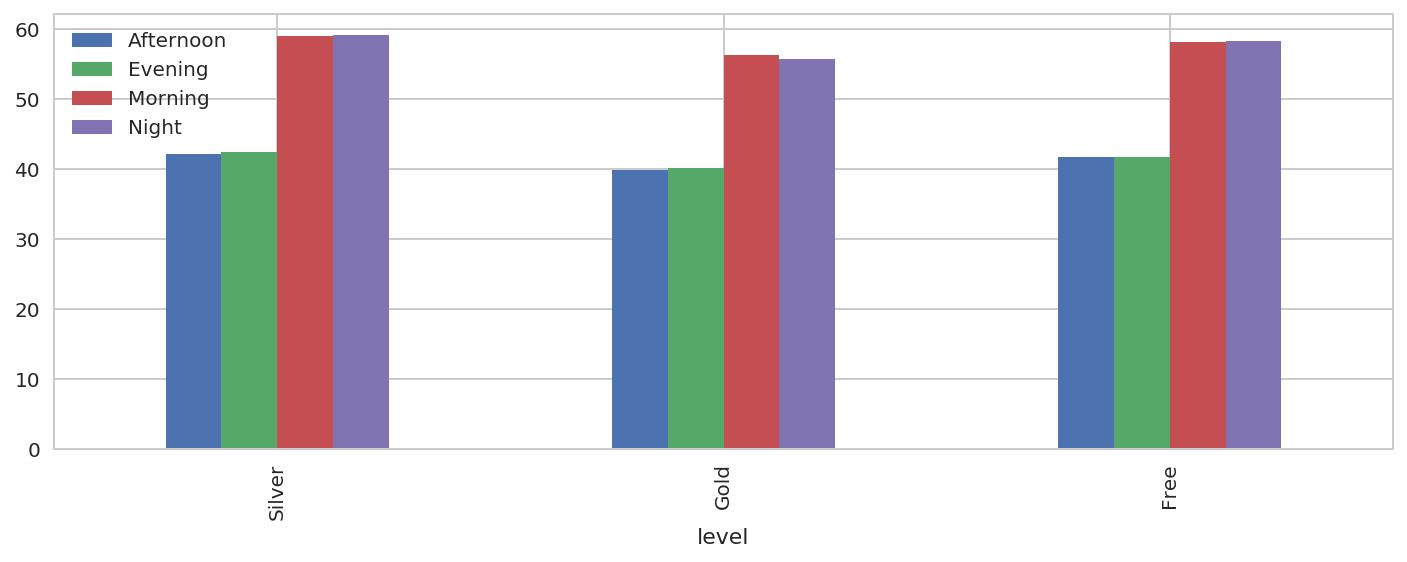

In [63]:
result_df.toPandas().plot.bar(x='level', figsize=(12, 4));

In [64]:
result_df.unpersist()

DataFrame[level: string, Afternoon: double, Evening: double, Morning: double, Night: double]

### 4.6 Distribution of Customers By Level:

In [65]:
result_df = (cust_df.select(['level', (F.when(col('gender') == 0, "Male").otherwise("Female")).alias('gender')])
                 .groupBy('level')
                 .pivot('gender')
                 .count()
                 .orderBy('level', ascending=False))

In [66]:
result_df.cache().show()

+-----+------+----+
|level|Female|Male|
+-----+------+----+
|    2|   201| 330|
|    1|   670| 971|
|    0|  1145|1683|
+-----+------+----+



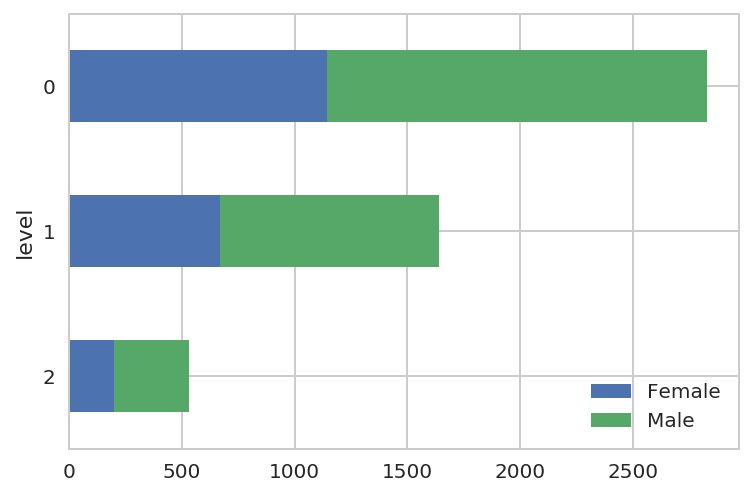

In [67]:
result_df.toPandas().set_index('level').plot.barh(stacked=True);

In [68]:
result_df.unpersist()

DataFrame[level: int, Female: bigint, Male: bigint]

### 4.7 Top 10 Zip Codes: Which regions consume most from this service:

In [69]:
result_df = cust_df.groupBy('zip').count().orderBy('count', ascending=False).limit(10)

In [70]:
result_df.cache().show()

+-----+-----+
|  zip|count|
+-----+-----+
| 5341|    4|
|80821|    4|
|71458|    3|
|31409|    3|
|70446|    3|
|20098|    3|
|80459|    3|
|57445|    3|
|78754|    3|
|47577|    3|
+-----+-----+



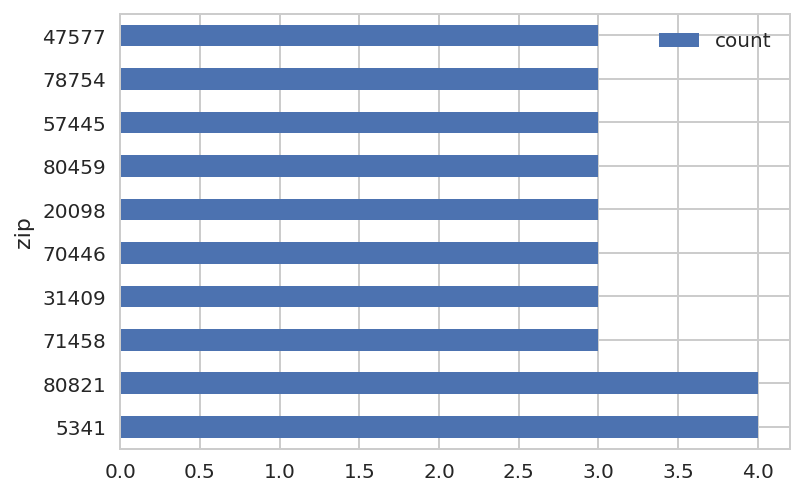

In [71]:
result_df.toPandas().plot.barh(x='zip');

In [72]:
result_df.unpersist()

DataFrame[zip: int, count: bigint]

### 4.8 Distribution of Customers By SignUp Campaign:

In [73]:
# Map from campaign number to actual campaign description
campaign_map = {0:"None", 1:"30DaysFree", 2:"SuperBowl",  3:"RetailStore", 4:"WebOffer"}

# Define a udf
udfIndexToCampaign = udf(lambda x: campaign_map[x], StringType())

In [74]:
result_df = (cust_df.select(udfIndexToCampaign("campaign").alias("campaign"))
                 .groupBy('campaign')
                 .count()
                 .orderBy('count', ascending=True))

In [75]:
result_df.cache().show()

+-----------+-----+
|   campaign|count|
+-----------+-----+
|  SuperBowl|  240|
|RetailStore|  489|
|       None|  608|
|   WebOffer|  750|
| 30DaysFree| 2913|
+-----------+-----+



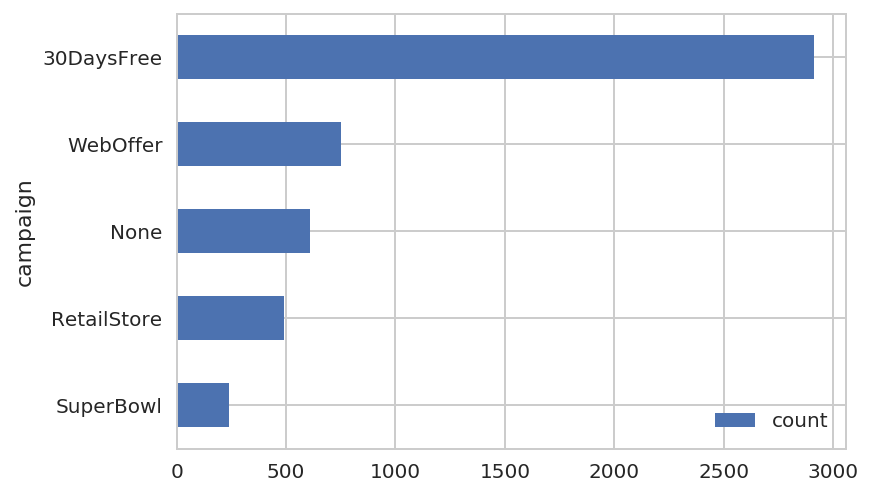

In [76]:
result_df.toPandas().plot.barh(x='campaign');

In [77]:
result_df.unpersist()

DataFrame[campaign: string, count: bigint]

### 4.9 Average Unique Track Count By Customer Level:

In [78]:
result_df = (music_df.select(['customer_id', 'track_id'])
                            .groupBy('customer_id')
                            .agg(F.countDistinct('track_id').alias('unique_track_count'))
                            .join(cust_df, on='customer_id', how='inner')
                            .select([udfIndexTolevel('level').alias('level'), 'unique_track_count'])
                            .groupBy('level')
                            .agg(F.avg('unique_track_count').alias('avg_unique_track_count')))

In [79]:
result_df.cache().show()

+------+----------------------+
| level|avg_unique_track_count|
+------+----------------------+
|Silver|     170.2772699573431|
|  Gold|    166.85310734463278|
|  Free|     170.9515558698727|
+------+----------------------+



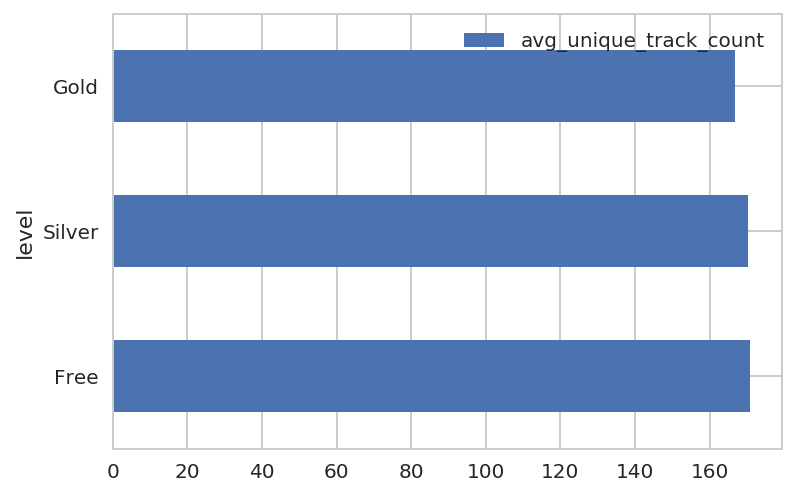

In [80]:
result_df.toPandas().sort_values(by='avg_unique_track_count', ascending=False).plot.barh(x='level');

In [81]:
result_df.unpersist()

DataFrame[level: string, avg_unique_track_count: double]

### 4.10 Mobile Tracks Count By Customer Level:

In [82]:
result_df = (music_df.select(['customer_id', 'track_id'])
                            .filter(col('is_mobile') == 1)
                            .groupBy('customer_id')
                            .count()
                            .withColumnRenamed('count', 'mobile_track_count')
                            .join(cust_df, on='customer_id', how='inner')
                            .select([udfIndexTolevel('level').alias('level'), 'mobile_track_count'])
                            .groupBy('level')
                            .agg(F.avg('mobile_track_count').alias('avg_mobile_track_count'))
                            .orderBy('avg_mobile_track_count'))

In [83]:
result_df.cache().show()

+------+----------------------+
| level|avg_mobile_track_count|
+------+----------------------+
|  Free|    100.01308345120226|
|Silver|     146.1614868982328|
|  Gold|    160.22033898305085|
+------+----------------------+



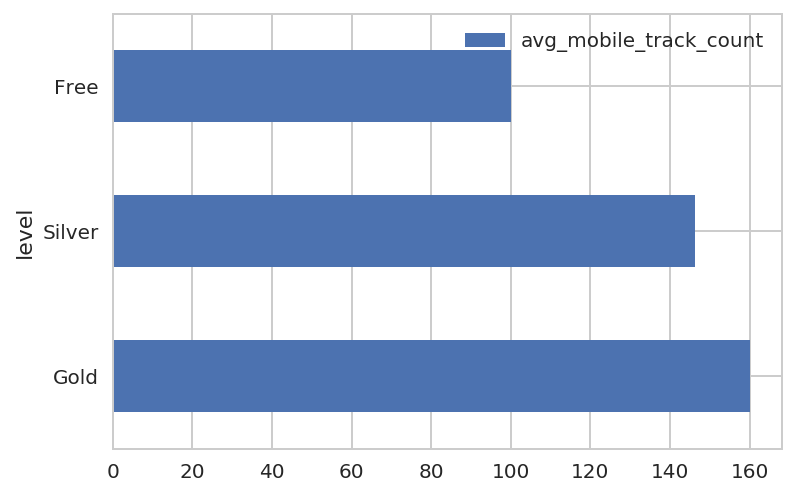

In [84]:
result_df.toPandas().sort_values(by='avg_mobile_track_count', ascending=False).plot.barh(x='level');

In [85]:
result_df.unpersist()

DataFrame[level: string, avg_mobile_track_count: double]

In [86]:
music_df.unpersist()
cust_df.unpersist()
click_df.unpersist()

DataFrame[event_id: int, customer_id: int, track_id: string, datetime: string, is_mobile: int, zip: int]

DataFrame[customer_id: int, name: string, gender: int, address: string, zip: int, sign_date: string, status: int, level: int, campaign: int, lnkd_with_apps: int]

DataFrame[event_id: int, customer_id: int, ad_clicked: int, datetime: string]

In [87]:
spark.stop()